# IMPORTS

In [3]:
#GENERAL IMPORTS
import datetime
import time
import pandas as pd
import datetime
import yfinance as yf   
import matplotlib.pyplot as plt
import numpy as np
import streamlit as st
import pandas as pd
import plotly.graph_objects as go

#SELENIUM IMPORTS
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
# from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys

#DATABASE IMPORTS
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db
from firebase_admin import auth
from firebase_admin import firestore
import schedule
import os

# DATA SCRAPPING

In [4]:
# ===== FUNCTION THAT OPEN THE BASE WEBPAGE IN A SIMULATED HEADLESS FIREFOX WINDOW AND RETURNS THE VALUES IN THE TABLE =====
    # Parameters : no parameters
    # Return : dataframe of the values of the table (header and the 8 rows)
    # Return example :   
    # scrapped_data_from_website_df 
    # 0    MEETING DATE 300-325 325-350 350-375 375-400 4...
    # 1    31/01/2024 0,0% 0,0% 0,0% 0,0% 15,5% 84,5% 0,0...
    # 2    20/03/2024 0,0% 0,0% 0,0% 0,0% 0,0% 0,0% 0,0% ...
    # 3    01/05/2024 0,0% 0,0% 0,0% 0,0% 0,0% 0,0% 0,0% ...
    # 4    12/06/2024 0,0% 0,0% 0,0% 0,0% 2,6% 23,7% 56,0...
    # 5    31/07/2024 0,0% 0,0% 0,0% 2,2% 20,9% 51,7% 21,...
    # 6    18/09/2024 0,0% 0,0% 2,1% 19,9% 50,2% 23,2% 4,...
    # 7    07/11/2024 0,0% 0,0% 1,4% 13,9% 40,0% 32,3% 10...
    # 8    18/12/2024 1,1% 11,3% 34,4% 33,9% 15,2% 3,5% 0...
def get_probabilities():
    options = Options()
    options.add_argument('--headless')

    driver = webdriver.Firefox(options=options)
    # driver = webdriver.Chrome(options=options)

    #OPEN FIRST URL AND GET SECOND URL
    driver.get("https://www.cmegroup.com/markets/interest-rates/cme-fedwatch-tool.html?redirect=/trading/interest-rates/countdown-to-fomc.html")
    driver.implicitly_wait(1) 

    #Switch to frame "cmeIframe-jtxelq2f"
    driver.switch_to.frame(driver.find_element(By.ID, "cmeIframe-jtxelq2f"))
    driver.implicitly_wait(1) 

    #Find the element "Form1" -> corresponds to the Quickstrike window integrated to the website
    folder = driver.find_element(By.ID, "Form1")
    driver.implicitly_wait(1)

    #Get the URL of the targetted QuickStrike table
    URL = folder.get_property('action')

    #CREATE A SECOND DRIVER TO OPEN THE RETRIEVED URL 
    driver_Click = webdriver.Firefox(options=options)
    # driver_Click = webdriver.Chrome(options=options)

    #OPEN SECOND URL
    driver_Click.get(URL)
    driver_Click.implicitly_wait(1) 
    
    #Click on the "Probabilities" component which ID is "ctl00_MainContent_ucViewControl_IntegratedFedWatchTool_lbPTree"
    folder_Click = driver_Click.find_element(By.ID, "ctl00_MainContent_ucViewControl_IntegratedFedWatchTool_lbPTree")
    folder_Click.click()
    
    #Gives an implicit wait for 5 seconds so that the QuickStrike table can load
    driver_Click.implicitly_wait(1) 

    df = pd.DataFrame()

    #Get data from the QuickStrike table and stores it in the df
    for i in range(2,15): #tr
        try:        
            current_xpath = "/html/body/form/div[3]/div[2]/div[3]/div[1]/div/div/div[1]/div/div[3]/div[3]/div/div/table[2]/tbody/tr[" + str(i) + "]"
            selected_row = driver_Click.find_element(By.XPATH, current_xpath).text
            print(selected_row)
            current_df=pd.DataFrame({selected_row})
            df = pd.concat([df, current_df], ignore_index=True)
            # print(i)
        except:
            break
        # df.iloc[i, j] = selected_row
            
    # df = df.set_index(['row', 'col'])   

    # current_df=pd.DataFrame({selected_row})
    
    # df.append(current_df, ignore_index=True)

    # df = pd.concat([df, current_df], ignore_index=True)
    driver_Click.quit()
    df = pd.melt(df, value_vars=df.columns)
    result_df = df['value']
    return result_df

### TEST get_probabilities()

In [5]:
df_scrapped_data_from_website = get_probabilities()

MEETING DATE 325-350 350-375 375-400 400-425 425-450 450-475 475-500 500-525 525-550
3/20/2024 0.0% 0.0% 0.0% 0.0% 4.0% 96.0%
5/1/2024 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.6% 18.0% 81.4%
6/12/2024 0.0% 0.0% 0.0% 0.0% 0.0% 0.3% 10.2% 52.8% 36.7%
7/31/2024 0.0% 0.0% 0.0% 0.0% 0.2% 6.0% 34.8% 43.5% 15.5%
9/18/2024 0.0% 0.0% 0.0% 0.1% 4.4% 26.8% 41.1% 23.3% 4.3%
11/7/2024 0.0% 0.0% 0.1% 2.4% 16.5% 34.5% 31.5% 13.1% 2.0%
12/18/2024 0.0% 0.0% 1.6% 11.8% 28.4% 32.5% 19.2% 5.7% 0.7%
1/29/2025 0.0% 1.0% 7.5% 21.4% 30.8% 24.9% 11.4% 2.8% 0.3%
3/12/2025 0.4% 3.4% 12.6% 24.9% 28.6% 19.9% 8.2% 1.9% 0.2%


### Buffer

In [6]:
df_buffer_scrapped_data_from_website_to_db = df_scrapped_data_from_website
type(df_buffer_scrapped_data_from_website_to_db)

pandas.core.series.Series

In [7]:
numberOfMeetingDates = (len(df_buffer_scrapped_data_from_website_to_db)-1)
numberOfMeetingDates

9

# CREDENTIALS DATABASE

In [8]:
notebook_path = os.path.abspath(".")  #Get the absolute path to the current directory

print(notebook_path)

cred = credentials.Certificate(notebook_path+'\quantitativetoolsdatabase-90b51ea9a1ca.json')
print(cred)
if not firebase_admin._apps:
    default_app = firebase_admin.initialize_app(cred, {"databaseURL" : "https://quantitativetoolsdatabase-default-rtdb.europe-west1.firebasedatabase.app/"})


c:\Users\pluto\Desktop\Projet Python\Firebase database


# TESTS DATABASE : UPLOAD

In [9]:
def insertdata(scrapped_data, date):
    for i in range(1,2):
        # db.reference("/Test").push().set(data)
        database_path = "/scrapped_FED_rates/" + str(date)

        ref = db.reference(database_path)
        ref.set(scrapped_data.to_dict())

today = datetime.date.today()
today = today.strftime("%Y-%m-%d")

insertdata(df_buffer_scrapped_data_from_website_to_db,'2024-03-02')

# TESTS DATABASE : DOWNLOAD

In [10]:
def query_data_by_date(input_date):
    database_path = "/scrapped_FED_rates/" + str(input_date)
    print(database_path)
    ref = db.reference(database_path)
    result = ref.get()
    result = pd.Series(result)
    return result 
        

df_buffer_scrapped_data_from_website = query_data_by_date('2024-03-01')
df_buffer_scrapped_data_from_website

/scrapped_FED_rates/2024-03-01


0    MEETING DATE 325-350 350-375 375-400 400-425 4...
1             3/20/2024 0.0% 0.0% 0.0% 0.0% 1.0% 99.0%
2    5/1/2024 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.6% 18...
3    6/12/2024 0.0% 0.0% 0.0% 0.0% 0.0% 0.3% 10.2% ...
4    7/31/2024 0.0% 0.0% 0.0% 0.0% 0.2% 6.0% 34.8% ...
5    9/18/2024 0.0% 0.0% 0.0% 0.1% 4.4% 26.8% 41.1%...
6    11/7/2024 0.0% 0.0% 0.1% 2.4% 16.5% 34.5% 31.5...
7    12/18/2024 0.0% 0.0% 1.6% 11.8% 28.4% 32.5% 19...
8    1/29/2025 0.0% 1.0% 7.5% 21.4% 30.8% 24.9% 11....
9    3/12/2025 0.4% 3.4% 12.6% 24.9% 28.6% 19.9% 8....
dtype: object

In [23]:
df_buffer_scrapped_data_from_website

0    MEETING DATE 325-350 350-375 375-400 400-425 4...
1             3/20/2024 0.0% 0.0% 0.0% 0.0% 4.0% 96.0%
2    5/1/2024 0.0% 0.0% 0.0% 0.0% 0.0% 0.0% 0.6% 18...
3    6/12/2024 0.0% 0.0% 0.0% 0.0% 0.0% 0.3% 10.2% ...
4    7/31/2024 0.0% 0.0% 0.0% 0.0% 0.2% 6.0% 34.8% ...
5    9/18/2024 0.0% 0.0% 0.0% 0.1% 4.4% 26.8% 41.1%...
6    11/7/2024 0.0% 0.0% 0.1% 2.4% 16.5% 34.5% 31.5...
7    12/18/2024 0.0% 0.0% 1.6% 11.8% 28.4% 32.5% 19...
8    1/29/2025 0.0% 1.0% 7.5% 21.4% 30.8% 24.9% 11....
9    3/12/2025 0.4% 3.4% 12.6% 24.9% 28.6% 19.9% 8....
dtype: object

# TEST SCHEDULE

In [19]:
def my_task():
    
    print("Performing the scheduled task...")

def ten_minutes():
    schedule.every(1).minutes.do(my_task)

schedule.every().saturday.at("22:37").do(ten_minutes)


# Run the scheduler indefinitely
while True:
    schedule.run_pending()
    time.sleep(1)

Performing the scheduled task...
Performing the scheduled task...
Performing the scheduled task...
Performing the scheduled task...
Performing the scheduled task...


KeyboardInterrupt: 

In [11]:
def task():
    print("Task running at Saturday 22:15 Paris time")

utc_offset = 1  # Replace with actual UTC offset based on your location

# Define the scheduling rule using a custom function
def weekly_at_paris_time(day_of_week, hour, minute):
    # Convert local Paris time to UTC by subtracting the offset
    utc_hour = (hour - utc_offset) % 24
    utc_minute = minute
    return schedule.every().wednesday.at(f"{utc_hour}:{utc_minute}")  # Wednesday is used for demonstration

# Schedule the task using the custom rule
weekly_at_paris_time('saturday', 22, 15).do(task)

while True:
    schedule.run_pending()
    time.sleep(1)  # Check for pending jobs every second

In [79]:
type(df_buffer_scrapped_data_from_website)

pandas.core.series.Series

# DATA TRANSFORMATION  : TRANSFORM RAW MEETING DATE DATA IN CLEAN DATAFRAME

In [80]:
# ===== FUNCTION THAT TAKES A probabilities_scrapped_raw STRING IN PARAMETER AND RETURNS THE DATE OF THIS STRING ===== 
    #Parameters : probabilities_scrapped_raw : the probabilities_scrapped_raw string
    #Return example : 13/12/2023
def dataSpliterDate(probabilities_scrapped_raw): # Split the data into date and percentage
    date_probabilities = probabilities_scrapped_raw[0].split(" ")
    # Extract the date
    returned_date = date_probabilities[0]
    return returned_date

In [81]:
# ===== FUNCTION TO TRANSFORM ONE LINE OF THE probabilities_scrapped_raw string in a transposed dataframe ===== 
    #Parameters : 
        # - dataheader : the data_headers_raw string : "MEETING DATE 325-350 350-375 375-400 400-425 4..."
        # - data_probabilities : the data_probabilities_raw string :"1/31/2024 0.0% 0.0% 0.0% 0.0% 6.7% 93.3%"
        # - index : a binary index to know if the data is the first one and to add two 0 to counter the default of the initial targetted QuickStrike table
    #Return : the sliced dataframe corresponding to a specific date
    #Return example : 
    # Rates Percentage
    # 0  350-375       0,0%
    # 1  375-400       0,0%
    # 2  400-425       0,0%
    # 3  425-450       0,0%
    # 4  450-475       0,0%
    # 5  475-500      95,5%
    # 6  500-525       4,5%
    # 7  525-550       0,0%
    # 8  550-575          0
    # 9  575-600          0
def dataSlicer(data_headers_raw, data_probabilities_raw, index):
    #Split the data into date and percentages
    data_headers_clean = data_headers_raw[0].split(" ")
    date_percentages_clean = data_probabilities_raw[0].split(" ")

    #Extract the date and percentages
    # date = date_percentages_clean[0]
    percentages = date_percentages_clean[1:]

    #Adjust the lenght of the first probabilities row (next date's probabilities)  to the lenght of the header row : "MEETING DATE 325-350 350-375 375-400 400-425 4..."
    while (len(percentages) != len(data_headers_clean[1:])):
        percentages.insert(0, "0,0%")  
    
    #Create a DataFrame
    df = pd.DataFrame([percentages], columns=data_headers_clean[1:])
    df = df.T
    df = df.reset_index()
    df.columns = ['Rates', 'Percentage']
    return df

### TEST dataSpliterDate() and dataSlicer()

In [82]:
Rates_df = pd.DataFrame({"Rates": ["0-25",	"25-50",	"50-75",	"75-100",	"100-125",	"125-150",	"150-175",	"175-200",	"200-225",	"225-250",	"250-275",	"275-300",	"300-325",	"325-350",	"350-375",	"375-400",	"400-425",	"425-450",	"450-475",	"475-500",	"500-525",	"525-550",	"550-575",	"575-600",	"600-625",	"625-650",	"650-675",	"675-700",	"700-725",	"725-750",	"750-775",	"775-800",	"800-825",	"825-850",	"850-875",	"875-900",	"900-925",	"925-950",	"950-975",	"975-1000"]})

#For each meeting date...
for i in range (numberOfMeetingDates, 0, -1):

    #Get the raw header: 0    MEETING DATE 325-350 350-375 375-400 400-425 4...
    header_scrapped_raw = df_buffer_scrapped_data_from_website.iloc[0]
    #Get the raw probabilities: 1    1/31/2024 0.0% 0.0% 0.0% 0.0% 6.7% 93.3%
    probabilities_scrapped_raw = df_buffer_scrapped_data_from_website.iloc[i] 

    #Delete the "MEETING" frome the header of the retrieve table
    header_scrapped_raw = header_scrapped_raw[7:]

    #Retransform the raw probabilities in a clean dataframe with dataSlicer() function defined above
    transformed_df_of_specific_meeting_date = dataSlicer([header_scrapped_raw], [probabilities_scrapped_raw], i) #for loop on 1
    
    #Get the date of the current probabilities
    Date_of_specific_meeting_date = dataSpliterDate([probabilities_scrapped_raw])

    #Merge the clean dataframe with the default rate interval
    Rates_df=pd.merge(transformed_df_of_specific_meeting_date,Rates_df, how='right', on='Rates')

    #Format final table
    Rates_df.rename(columns={'Percentage': Date_of_specific_meeting_date}, inplace=True)
    Rates_df = Rates_df.fillna("0,0%")
Rates_df

,Rates,3/20/2024,5/1/2024,6/12/2024,7/31/2024,9/18/2024,11/7/2024,12/18/2024,1/29/2025,3/12/2025
0,0-25,"0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%"
1,25-50,"0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%"
2,50-75,"0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%"
3,75-100,"0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%"
4,100-125,"0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%"
5,125-150,"0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%"
6,150-175,"0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%"
7,175-200,"0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%"
8,200-225,"0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%"
9,225-250,"0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%","0,0%"


# FINAL FUNCTION CALLING OTHER FUNCTION AND MERGING DATA IN A SINGLE DATAFRAME

In [83]:
def dfRatesMerger():

    scrapped_data_from_website_df  = get_probabilities()

    Rates_df = pd.DataFrame({"Rates": ["0-25",	"25-50",	"50-75",	"75-100",	"100-125",	"125-150",	"150-175",	"175-200",	"200-225",	"225-250",	"250-275",	"275-300",	"300-325",	"325-350",	"350-375",	"375-400",	"400-425",	"425-450",	"450-475",	"475-500",	"500-525",	"525-550",	"550-575",	"575-600",	"600-625",	"625-650",	"650-675",	"675-700",	"700-725",	"725-750",	"750-775",	"775-800",	"800-825",	"825-850",	"850-875",	"875-900",	"900-925",	"925-950",	"950-975",	"975-1000"]})

    #For each meeting date...
    for i in range (numberOfMeetingDates, 0, -1):

        #Get the raw header
        header_scrapped_raw = scrapped_data_from_website_df.iloc[0]
        #Get the raw probabilities
        probabilities_scrapped_raw = scrapped_data_from_website_df.iloc[i] 

        #Delete the "MEETING" from the header of the retrieve table
        header_scrapped_raw = header_scrapped_raw[8:]

        #Retransform the raw probabilities in a clean dataframe
        transformed_dateframe_of_specific_meeting_date = dataSlicer([header_scrapped_raw], [probabilities_scrapped_raw], i) #for loop on 1
        Date_of_specific_meeting_date = dataSpliterDate([probabilities_scrapped_raw])

        #Merge the clean dataframe with the default rate interval
        Rates_df=pd.merge(transformed_dateframe_of_specific_meeting_date,Rates_df, how='right', on='Rates')

        #Format final table
        Rates_df.rename(columns={'Percentage': Date_of_specific_meeting_date}, inplace=True)
        Rates_df = Rates_df.fillna("0,0%")

    Rates_df.replace('0,0%', 0, inplace=True)
    Rates_df = (Rates_df.loc[(Rates_df[[Rates_df.columns[0]]]!= 0).all(axis=1) | (Rates_df[[Rates_df.columns[0]]]!= 0).all(axis=1) | (Rates_df[[Rates_df.columns[0]]]!= 0).all(axis=1) | (Rates_df[[Rates_df.columns[0]]]!= 0).all(axis=1) | (Rates_df[[Rates_df.columns[0]]]!= 0).all(axis=1) | (Rates_df[[Rates_df.columns[0]]]!= 0).all(axis=1) | (Rates_df[[Rates_df.columns[0]]]!= 0).all(axis=1) | (Rates_df[[Rates_df.columns[0]]]!= 0).all(axis=1) | (Rates_df[[Rates_df.columns[0]]]!= 0).all(axis=1)]).T

    Rates_df.columns = Rates_df.iloc[0]
    Rates_df = Rates_df.iloc[1:]         
    return Rates_df

### TEST dfRatesMerger()

In [ ]:
final_df = dfRatesMerger()
final_df.loc[:, '500-525']

### Buffer

In [11]:
final_scrapped_df = final_df
final_scrapped_df

Rates,0-25,25-50,50-75,75-100,100-125,125-150,150-175,175-200,200-225,225-250,...,750-775,775-800,800-825,825-850,850-875,875-900,900-925,925-950,950-975,975-1000
3/20/2024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5/1/2024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6/12/2024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7/31/2024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9/18/2024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11/7/2024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12/18/2024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/29/2025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3/12/2025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# REWORK THE DATAFRAME TO DISPLAY IN ON A GRAPH

In [12]:
dataframe_from_database = final_scrapped_df

#Map function to replace European percentage type values in decimal type values : the percentage '65.0%' will be converted to '68.5 and '0,00' will be converted to '0'
def convert_percentage(x):
    if isinstance(x, str):
        value = (x.replace('%', ''))     
        # value = value.replace(',', '.')
        return value
    else:
        return x
        
#Function to convert the range value in column names to a single rate : 475-500' will be converted to '5'
def convertRateRanges(dataframe_from_database):
    #Define the range values
    ranges = dataframe_from_database.columns

    #Convert each range to its upper rate : the rate range '475-500' will be converted to '5'
    upperpoints = []
    for range_str in ranges:
        # Split the range string into its two values
        values = range_str.split("-")
        start_value = int(values[0])
        end_value = int(values[1])

        # Calculate the upperpoint
        upperpoint = end_value /100

        # Add the upperpoint to the list of upperpoints
        upperpoints.append(upperpoint)

    # print(upperpoints, "\n")

    dataframe_from_database.columns = upperpoints

    dataframe_from_database = dataframe_from_database.T
    # print(dataframe_from_database)
    return dataframe_from_database

def transformReworkedDataframeToDisplayableDataframe(dataframe_from_database):
    #Replace European percentage type values in decimal type values 
    dataframe_from_database = dataframe_from_database.map(convert_percentage)

    #Convert all percentages probabilities to float64
    for col in dataframe_from_database.columns:
        if pd.api.types.is_numeric_dtype(dataframe_from_database[col]):
            continue
        try:
            dataframe_from_database[col] = pd.to_numeric(dataframe_from_database[col])
        except:
            pass

    #Convert the range value in column names to a single rate :
    dataframe_from_database = convertRateRanges(dataframe_from_database)

    # print(dataframe_from_database)

    selected_columns = dataframe_from_database.columns.tolist()
    df_avg = pd.DataFrame()


    for column in selected_columns:
        avg = 0
        for i in range (0,len(dataframe_from_database)):
            # print("dataframe_from_database[column].index[i] : ",dataframe_from_database[column].index[i])
            # print("dataframe_from_database[column].iloc[i] : ", dataframe_from_database[column].iloc[i])
            avg = dataframe_from_database[column].index[i] * dataframe_from_database[column].iloc[i] + avg
            current_df=pd.DataFrame({avg/100})
        df_avg = pd.concat([df_avg, current_df], ignore_index=True)

    print("df_avg : ", df_avg)

    

    # selected_columns = [dataframe_from_database.columns[0], dataframe_from_database.columns[1], dataframe_from_database.columns[2], dataframe_from_database.columns[3], dataframe_from_database.columns[4], dataframe_from_database.columns[5], dataframe_from_database.columns[6]]

    

    print("selected_columns", selected_columns, "\n")

    max_values_probability_rate = dataframe_from_database[selected_columns].idxmax(axis=0)

    print(type(max_values_probability_rate))

    print("max_values_probability_rate : ", max_values_probability_rate)

    # print("max_values_indices", max_values_probability_rate, "\n")

    max_probability = dataframe_from_database.max(axis=0)

    # print("max_values", max_probability, "\n")

    # # Print the indices of the maximum values in each row
    # print("max_values_indices", max_values_indices)

    df_to_display_in_graph = max_values_probability_rate.to_frame()
    print(df_to_display_in_graph)
    df_to_display_in_graph['Probabilities']=(max_probability)
    # Print the DataFrame
    df_to_display_in_graph.columns = ['Upper range rate','Probabilities']
    df_to_display_in_graph2 = pd.concat([df_to_display_in_graph.reset_index(drop=False), df_avg], axis = 1)
    df_to_display_in_graph2.index = df_to_display_in_graph.index
    df_to_display_in_graph2.rename(columns = {0 : 'Average'}, inplace = True)


    return df_to_display_in_graph2

df_to_display_in_graph = transformReworkedDataframeToDisplayableDataframe(dataframe_from_database)

df_to_display_in_graph

df_avg :           0
0  5.47375
1  5.39675
2  5.23425
3  5.06400
4  4.87175
5  4.72500
6  4.55600
7  4.40825
8  4.31125
selected_columns ['3/20/2024', '5/1/2024', '6/12/2024', '7/31/2024', '9/18/2024', '11/7/2024', '12/18/2024', '1/29/2025', '3/12/2025'] 

<class 'pandas.core.series.Series'>
max_values_probability_rate :  3/20/2024     5.50
5/1/2024      5.50
6/12/2024     5.25
7/31/2024     5.00
9/18/2024     4.75
11/7/2024     4.75
12/18/2024    4.50
1/29/2025     4.50
3/12/2025     4.25
dtype: float64
               0
3/20/2024   5.50
5/1/2024    5.50
6/12/2024   5.25
7/31/2024   5.00
9/18/2024   4.75
11/7/2024   4.75
12/18/2024  4.50
1/29/2025   4.50
3/12/2025   4.25


,index,Upper range rate,Probabilities,Average
3/20/2024,3/20/2024,5.50,89.5,5.47375
5/1/2024,5/1/2024,5.50,61.9,5.39675
6/12/2024,6/12/2024,5.25,52.4,5.23425
7/31/2024,7/31/2024,5.00,43.3,5.06400
9/18/2024,9/18/2024,4.75,37.2,4.87175
11/7/2024,11/7/2024,4.75,35.5,4.72500
12/18/2024,12/18/2024,4.50,32.9,4.55600
1/29/2025,1/29/2025,4.50,28.7,4.40825
3/12/2025,3/12/2025,4.25,28.4,4.31125


# DISPLAY THE GRAPH

<module 'matplotlib.pyplot' from 'c:\\Users\\pluto\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

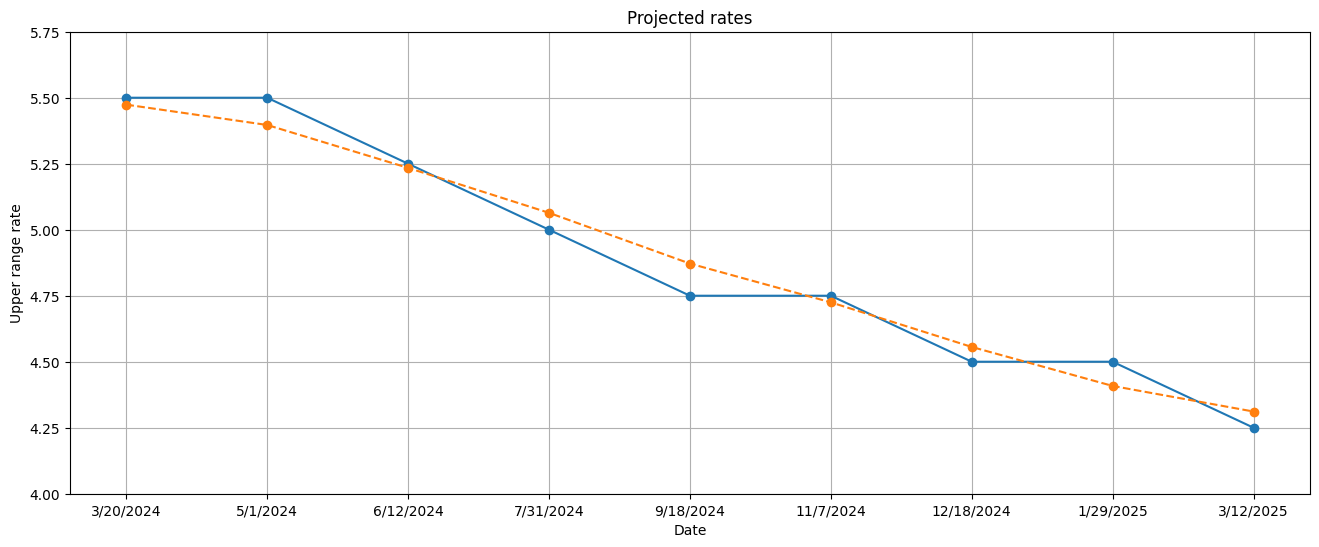

In [13]:
# ===== PYPLOT =====
# Create the line graph
def createPlot(df_to_display_in_graph):
    plt.figure(figsize=(16, 6))
    plt.plot(df_to_display_in_graph.index, df_to_display_in_graph['Upper range rate'], marker='o', linestyle='-')
    plt.plot(df_to_display_in_graph.index, df_to_display_in_graph['Average'], marker='o', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Upper range rate')
    plt.title('Projected rates')
    plt.grid(True)

    # Scale Y axis by 0.25
    def make_increment(start, end, num_steps):
        return [start + i * (end - start) / (num_steps - 1) for i in range(num_steps)]

    max_value = df_to_display_in_graph['Upper range rate'].max()
    min_value = df_to_display_in_graph['Upper range rate'].min()
    increment_values = make_increment(max_value+0.25, min_value-0.25, int((max_value-min_value)/0.25)+3)
    plt.gca().set_yticks(increment_values)

    return plt
createPlot(df_to_display_in_graph)